### Project Title: 
- **Understanding the Impact of Data Poisoning on Financial Fraud Detection: Thresholds and Feature Sensitivity**

This research investigates the vulnerability of AI-based financial fraud detection models to data poisoning attacks, aiming to identify (1) the poisoning threshold at which models fail, (2) feature-level sensitivities exploited by attackers, and (3) lightweight strategies for detecting and mitigating poisoned data.

## Project Outline

**1. Data Preparation**  
 1.0 Inspect Data Format and Understand Feature Meanings  
 1.1 Preliminary Detection of Outliers  
 1.2 Feature Standardization / Normalization  
 1.3 Train-Test Split (Stratified Sampling)

**2. Baseline Model Training and Evaluation**  
 2.1 Logistic Regression (`class_weight='balanced'`)  
 2.2 Random Forest (`class_weight='balanced'`)  
 2.3 XGBoost (`scale_pos_weight`)  
 2.4 Isolation Forest (Unsupervised)

**3. Summary and Transition**  
 3.1 Baseline Model Comparison  
 3.2 Conclusion and Next Step: Poisoning Experiments

# 1 Data Preparation

## 1.1 Inspect data format and understand feature meanings 

In [26]:
import pandas as pd

df = pd.read_csv("/Users/gin/Documents/005. Projects/fraud_poisoning_study/Data/raw_creditcard.csv")

In [28]:
# View the first 5 rows of the dataset
print("First 5 rows of the dataset:")
print(df.head())

# Check the shape of the dataset
print("\nDataset dimensions (rows, columns):")
print(df.shape)

# See data types and non-null counts
print("\nDataset info (column types & non-null counts):")
print(df.info())

# Count the number of missing values in each column
print("\nMissing values per column:")
print(df.isnull().sum())

# Show basic statistics for numeric columns
print("\nDescriptive statistics for numeric features:")
print(df.describe())

First 5 rows of the dataset:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

   

Noted, the columns V1 to V28 are anonymized features that were extracted from the original credit card transaction data using Principal Component Analysis (PCA). PCA is a dimensionality reduction technique that transforms high-dimensional data into a smaller set of uncorrelated components while preserving as much variance as possible. These transformed variables do not have specific human-interpretable meanings, but they still contain useful information for detecting fraud.

In [34]:
# Count the number of each class
print("Class distribution:")
print(df['Class'].value_counts())

# Calculate class percentages
fraud_percent = df['Class'].value_counts(normalize=True) * 100
print("\nPercentage of each class:")
print(fraud_percent)

Class distribution:
Class
0    284315
1       492
Name: count, dtype: int64

Percentage of each class:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


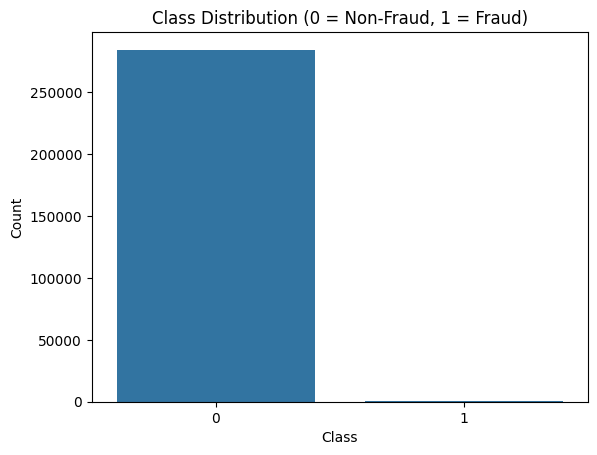

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Class', data=df)
plt.title("Class Distribution (0 = Non-Fraud, 1 = Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

The dataset contains a total of **284,807** credit card transactions. Among them, only **492** transactions (approximately 0.17%) are labeled as fraudulent, while the remaining 284,315 transactions (about 99.83%) are non-fraudulent. 

This indicates a **highly imbalanced dataset**, which poses a significant challenge for fraud detection models and requires special handling during model training and evaluation.

Because only 0.17% of the transactions are fraudulent, a model could achieve over 99% accuracy by simply predicting all transactions as non-fraud. However, such a model would fail to detect actual fraud cases. Therefore, accuracy is not a reliable metric in this context. 

Instead, we need to focus on metrics like **Recall, Precision, F1-score, and AUC**, and apply techniques to handle class imbalance during model training.

## 1.2 Preliminary detection of outliers

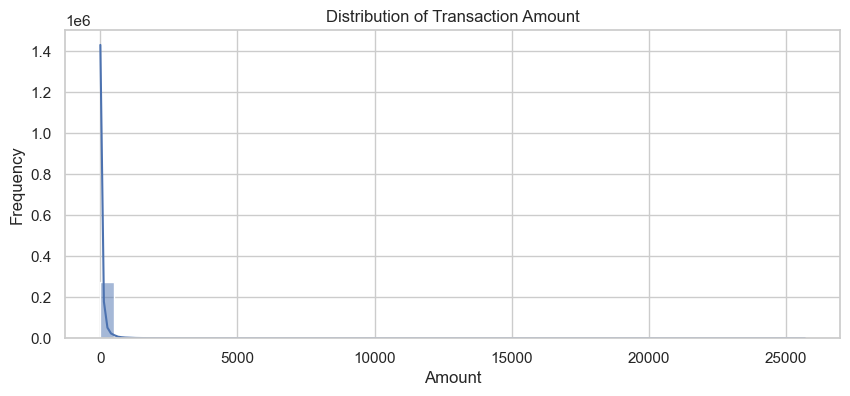

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot distribution of 'Amount'
plt.figure(figsize=(10, 4))
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Distribution of Transaction Amount")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

Need to further narrow it down to have a closer look.

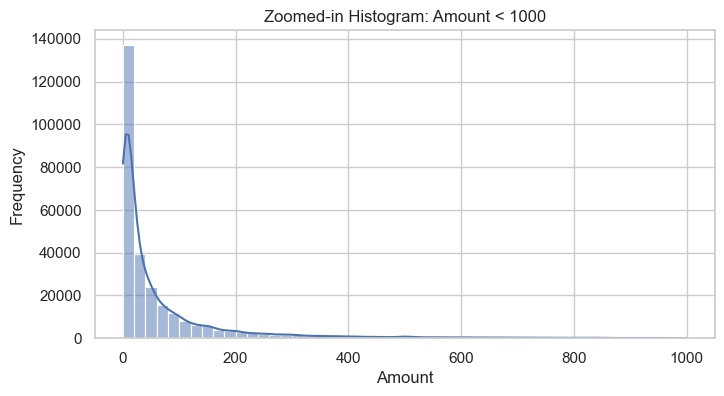

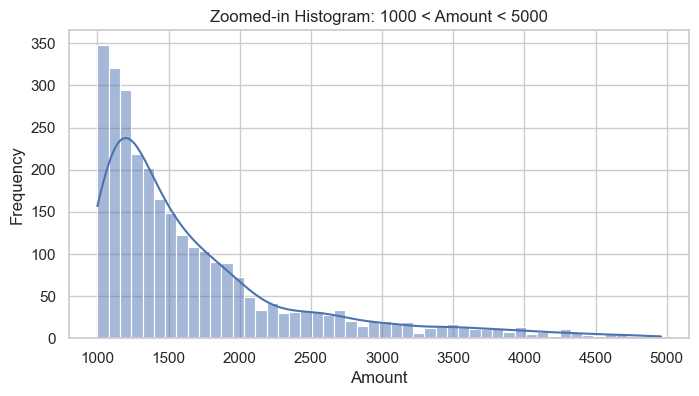

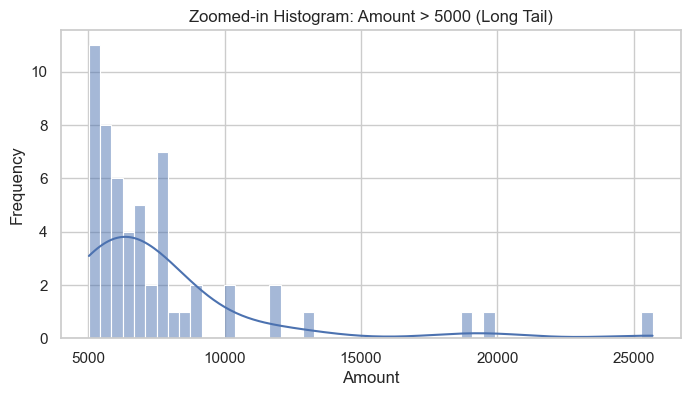

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Amount < 1000
plt.figure(figsize=(8, 4))
sns.histplot(df[df['Amount'] < 1000]['Amount'], bins=50, kde=True)
plt.title("Zoomed-in Histogram: Amount < 1000")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

# 1000 < Amount < 5000
plt.figure(figsize=(8, 4))
sns.histplot(df[(df['Amount'] > 1000) & (df['Amount'] < 5000)]['Amount'], bins=50, kde=True)
plt.title("Zoomed-in Histogram: 1000 < Amount < 5000")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

# Amount > 5000
plt.figure(figsize=(8, 4))
sns.histplot(df[df['Amount'] > 5000]['Amount'], bins=50, kde=True)
plt.title("Zoomed-in Histogram: Amount > 5000 (Long Tail)")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

#### Purpose of the polt (Distribution of Transaction Amount):

- To visualize the overall distribution of transaction amounts and assess whether the data is skewed or contains extreme values (outliers).

#### Brief analysis:

- The histogram shows that the transaction amount is heavily right-skewed, meaning most transactions are of low value, while a small number of transactions have extremely high amounts. This creates a “long tail” on the right side of the plot. The presence of such a long tail suggests the existence of outliers that may influence model training and require transformation (e.g., log-scaling) or normalization.

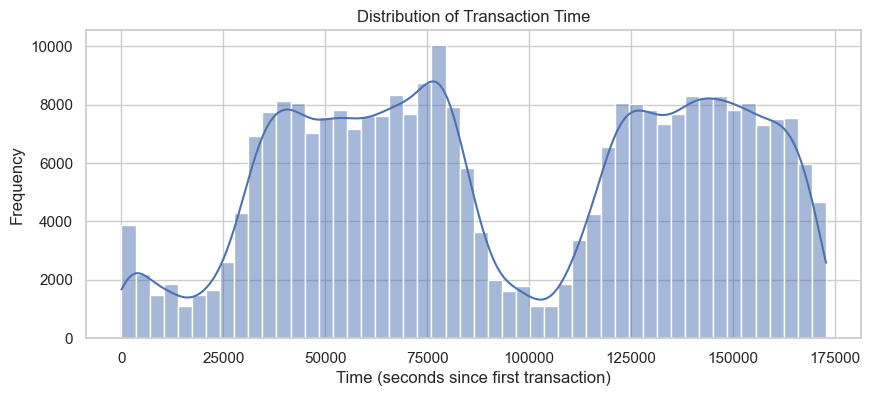

In [12]:
# Plot distribution of 'Time'
plt.figure(figsize=(10, 4))
sns.histplot(df['Time'], bins=50, kde=True)
plt.title("Distribution of Transaction Time")
plt.xlabel("Time (seconds since first transaction)")
plt.ylabel("Frequency")
plt.show()

#### Purpose of the plot (Distribution of Transaction Time):
- To visualize the overall distribution of transaction times and identify any patterns or irregularities that may affect model performance or indicate behavioral trends.

#### Brief analysis:
- The histogram shows that transaction activity is not evenly distributed over time. Instead, it displays two clear peaks separated by a period of lower activity. This suggests the presence of cyclical behavior in the data, possibly corresponding to business hours and off-hours. There is no apparent skewness or presence of extreme outliers in the Time feature.

- Although the Time feature does not show extreme skewness or obvious outliers, its distribution indicates cyclical transaction patterns, such as peak and off-peak hours. These temporal structures may be correlated with fraudulent behavior.

Since the Time feature did not exhibit clear outliers, we need to pay further attention to the Amount feature, which may contain significant extremes and offer stronger predictive signals.

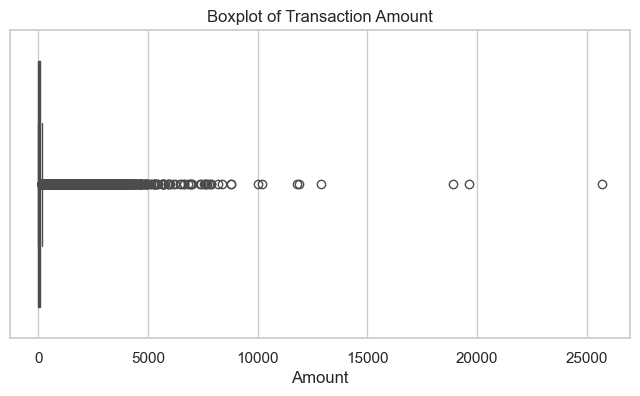

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Amount'])
plt.title("Boxplot of Transaction Amount")
plt.xlabel("Amount")
plt.show()

#### Purpose of the plot (Boxplot of Transaction Amount):
To detect the presence of outliers in the Amount feature by visualizing the spread and distribution of transaction values.

#### Brief analysis:
The boxplot clearly reveals the presence of many outliers on the higher end of the transaction amount range. Most transactions are concentrated near the lower end, while a small number of transactions extend far beyond the upper quartile. These high-value transactions appear as individual points outside the whiskers, confirming the long-tailed nature of the distribution.

Although these extreme values are uncommon, they may carry important signals related to fraud and should not be discarded without further investigation.

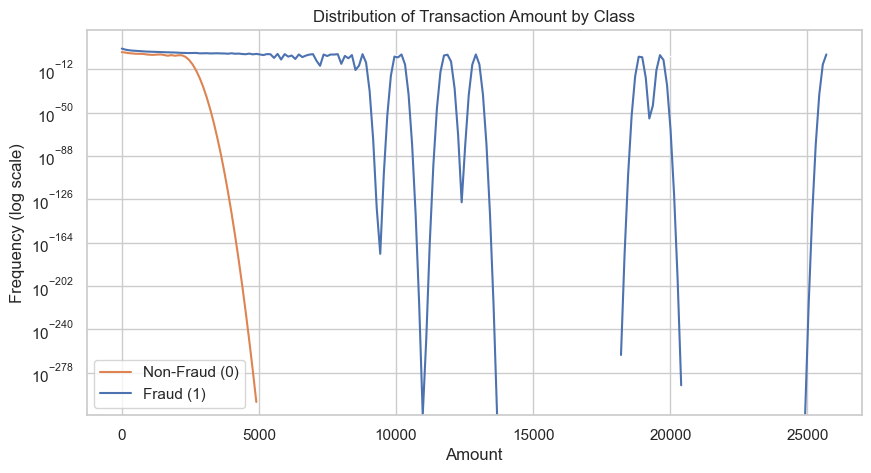

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='Amount', hue='Class', bins=50, log_scale=(False, True), kde=True)
plt.title("Distribution of Transaction Amount by Class")
plt.xlabel("Amount")
plt.ylabel("Frequency (log scale)")
plt.legend(['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

#### Purpose of the plot (Distribution of Transaction Amount by Class):
- To compare the distribution of transaction amounts between fraudulent and non-fraudulent transactions and determine whether high-value transactions are associated with fraud.

#### Brief analysis:
- The histogram, plotted on a log-scaled y-axis, reveals a stark contrast between the two classes. **Non-fraudulent transactions are heavily concentrated at lower amounts and taper off rapidly.** 

- **Fraudulent transactions are distributed across a broader range and appear more frequently among higher transaction values.** This suggests that high-value transactions are more likely to be fraudulent.

## 1.3 Feature Standardization / Normalization

In [38]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Apply log transformation to 'Amount' to reduce right-skew and long tail
df['Amount_log'] = np.log1p(df['Amount'])  # log1p handles 0 safely

# Initialize a StandardScaler instance
scaler = StandardScaler()

# Standardize the log-transformed 'Amount' feature
df['Amount_scaled'] = scaler.fit_transform(df['Amount_log'].values.reshape(-1, 1))

# Standardize the 'Time' feature
df['Time_scaled'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

In [40]:
# Create a new DataFrame for modeling, excluding raw and intermediate columns
df_model = df.copy()  # Work on a copy to avoid overwriting df
df_model = df_model.drop(['Amount', 'Time', 'Amount_log'], axis=1)

In [42]:
# Check if the changes applied
print(df_model.columns)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class',
       'Amount_scaled', 'Time_scaled'],
      dtype='object')


#### Purpose:
- To prepare the Amount and Time features for modeling by applying transformations that reduce skewness and align them with a consistent numerical scale. These steps help prevent models from being biased toward features with larger numeric ranges and improve overall learning performance.

#### What we applied:
1. Applied a log transformation (log1p) to the Amount feature to reduce its heavy right-skew and long tail.
2. Used StandardScaler to standardize both the log-transformed Amount and the original Time feature.
3. Created two new columns: Amount_scaled and Time_scaled.
4. Built a clean modeling dataset df_model by dropping the original Amount, Time, and intermediate Amount_log columns, while retaining all scaled and PCA-transformed features.

## 1.4 Train-test split (with stratified sampling to preserve class distribution)

We applied an 80/20 train-test split with stratification on the Class label. This ensures a balanced representation of fraud cases in both sets, preserves enough fraud samples in the training set for potential poisoning, and allows for fair evaluation on untouched test data.

In [44]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = df_model.drop('Class', axis=1)  # All features
y = df_model['Class']               # Target label (fraud or not)

# Perform stratified train-test split to preserve fraud ratio in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [46]:
# Check class distribution in the training and test sets
print("Training set class distribution:\n", y_train.value_counts(normalize=True))
print("Test set class distribution:\n", y_test.value_counts(normalize=True))

Training set class distribution:
 Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
Test set class distribution:
 Class
0    0.99828
1    0.00172
Name: proportion, dtype: float64


In [48]:
# Combine X_train and y_train into a single DataFrame for easier processing
train_df = X_train.copy()
train_df['Class'] = y_train

# Also combine X_test and y_test if needed later
test_df = X_test.copy()
test_df['Class'] = y_test

In [50]:
import os

# Create a folder to store clean data if not exists
os.makedirs('data/clean', exist_ok=True)

# Save the clean training and test sets
train_df.to_csv('data/clean/train.csv', index=False)
test_df.to_csv('data/clean/test.csv', index=False)

## 1.5 Baseline Model Training and Evaluation

In this section, we focus on fitting models on the training set, includes:
- Logistic Regression (class_weight='balanced')
- Random Forest (class_weight='balanced')
- XGBoost (scale_pos_weight)¶
- Isolation Forest (on X_train only if unsupervised)

In the baseline stage, to minimize complexity while ensuring fairness, we adopt **class_weight='balanced'** for logistic regression and random forest models without applying any sampling techniques. This approach allows us to establish a clean and unbiased performance benchmark for future comparisons involving poisoned data and advanced imbalance handling methods.

### 1.5.1 Logistic Regression (`class_weight='balanced'`)

We trained a logistic regression model using the training set. To address the extreme class imbalance, we set `class_weight='balanced'`, which re-weights the loss function to give more importance to minority class samples.

In [89]:
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model with class_weight to handle imbalance
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Train the model on the training set
lr_model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.98      0.99     56962

AUC Score: 0.9711624872233643


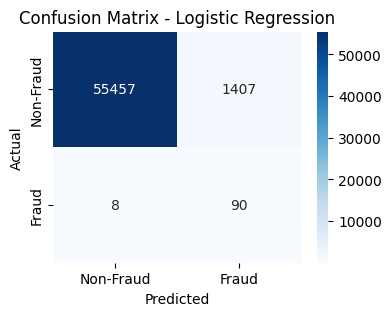

In [91]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = lr_model.predict(X_test)               # predicted class labels
y_proba = lr_model.predict_proba(X_test)[:, 1]  # predicted probability of class 1 (fraud)

# Print classification metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Fraud", "Fraud"], yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

#### Metric Interpretation:

- Class 0 stands for non-fraud, Class 1 stands for fraud transaction.

- **Precision (Class 1 = Fraud): 0.06**  
  The model produces a large number of false positives. Only 6% of predicted fraud cases are actually fraud. Precision is low due to many normal transactions being misclassified as fraud.

- **Recall (Class 1 = Fraud): 0.92**  
  The model successfully captures 92% of all actual fraud cases. This is a strong recall and indicates that the model is effective at not missing fraudulent transactions.

- **F1-score (Class 1 = Fraud): 0.11**  
  A low F1-score reflects the imbalance between high recall and low precision. It suggests that while most frauds are detected, many predictions are incorrect.

- **Accuracy: 0.98**  
  Although this looks high, accuracy is not meaningful in highly imbalanced datasets where the majority class dominates.

- **AUC Score: 0.97**  
  The model has strong ability to distinguish between fraud and non-fraud across various thresholds. AUC above 0.9 is considered excellent.

#### Overall Performance:

- The model achieves excellent recall and AUC, making it suitable for use cases where catching as many fraud cases as possible is a priority. Although the model is good at catching fraud cases (high recall), it also wrongly flags many normal cases as fraud (low precision). This may lead to unnecessary interventions or operational costs (e.g., transaction blocks, customer notifications, manual reviews).

In [111]:
def log_result(result_dict, filename='results/baseline_results.csv'):
    import os, csv

    os.makedirs(os.path.dirname(filename), exist_ok=True)

    fieldnames = ['Attack Type', 'Polluted Ratio', 'Model', 'AUC', 'F1', 'Precision', 'Recall']
    new_row = [str(result_dict[k]) for k in fieldnames]

    # Check if row already exists
    if os.path.exists(filename):
        with open(filename, mode='r') as file:
            existing_rows = list(csv.reader(file))
            if new_row in existing_rows:
                print("This result already exists in the log. Skipping.")
                return

    # Write new row
    with open(filename, mode='a', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        if file.tell() == 0:
            writer.writeheader()
        writer.writerow(result_dict)

In [95]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

y_pred = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:, 1]

# Log baseline result
log_result({
    'Attack Type': 'Clean',
    'Ratio': 0,
    'Model': 'Logistic Regression',
    'AUC': roc_auc_score(y_test, y_proba),
    'F1': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred)
})

### 1.5.2 Random Forest (`class_weight='balanced'`)

In [105]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest model with class_weight to handle imbalance
rf_model = RandomForestClassifier(
    class_weight='balanced', 
    n_estimators=100, 
    max_depth=None, 
    random_state=42, 
    n_jobs=-1  # use all CPU cores
)

# Train the model on the training set
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.74      0.84        98

    accuracy                           1.00     56962
   macro avg       0.98      0.87      0.92     56962
weighted avg       1.00      1.00      1.00     56962

AUC Score: 0.9530002842442548


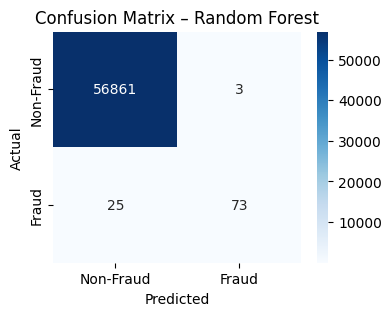

In [107]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)                # predicted class labels
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]   # predicted probability of class 1 (fraud)

# Print classification metrics
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("AUC Score:", roc_auc_score(y_test, y_proba_rf))

# Plot confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(4,3))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Random Forest")
plt.show()

#### Metric Interpretation:¶

- **Precision (Class 1 = Fraud): 0.96**  
The model produces very few false positives. 96% of transactions predicted as fraud are indeed fraudulent. This high precision indicates the model is highly reliable when it raises a fraud alert.

- **Recall (Class 1 = Fraud): 0.74**  
The model correctly identifies 74% of all actual fraud cases. While lower than Logistic Regression, this is still a strong recall value and reflects a good ability to detect fraudulent activity.

- **F1-score (Class 1 = Fraud): 0.84**  
The F1-score is high, indicating a strong balance between precision and recall. This suggests the model performs well both in detecting fraud and avoiding false alarms.

- **Accuracy: 1.00**  
Although accuracy is often misleading in imbalanced datasets, the model achieves nearly perfect classification on the test set. However, this result is largely influenced by the dominance of the majority class.

- **AUC Score: 0.95**  
The model demonstrates excellent ability to separate fraud from non-fraud across different thresholds. AUC above 0.9 is considered strong, confirming the model's overall discriminative power.

#### Overall Performance:
- The model presents a well-balanced and effective baseline. Compared to Logistic Regression, it significantly improves precision while maintaining strong recall and AUC. This makes it useful in scenarios where false positives are costly or disruptive. Although it does not capture quite as many fraud cases as Logistic Regression, the reduction in false alarms may lead to a more stable deployment in real-world systems.

In [113]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

log_result({
    'Attack Type': 'Clean',
    'Polluted Ratio': 0,
    'Model': 'Random Forest',
    'AUC': roc_auc_score(y_test, y_proba_rf),
    'F1': f1_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf)
})

### 1.5.3 XGBoost (`scale_pos_weight`)

In [117]:
from xgboost import XGBClassifier

# Initialize XGBoost model with imbalance handling
xgb_model = XGBClassifier(
    scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)

# Train the model on the training set
xgb_model.fit(X_train, y_train)

/Users/gin/anaconda3/envs/fraud_poisoning_study/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [04:14:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=-1,
              num_parallel_tree=None, ...)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.53      0.86      0.66        98

    accuracy                           1.00     56962
   macro avg       0.77      0.93      0.83     56962
weighted avg       1.00      1.00      1.00     56962

AUC Score: 0.9755158746109586


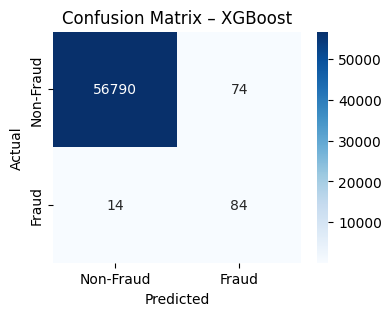

In [119]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)                # predicted class labels
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]   # predicted probability of class 1 (fraud)

# Print classification metrics
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("AUC Score:", roc_auc_score(y_test, y_proba_xgb))

# Plot confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(4,3))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – XGBoost")
plt.show()

#### Metric Interpretation:

- **Precision (Class 1 = Fraud): 0.53**  
The model correctly identifies over half of the transactions it labels as fraud. While this precision is lower than that of Random Forest, it still represents a substantial improvement over Logistic Regression, and indicates moderate reliability when a fraud alert is triggered.

- **Recall (Class 1 = Fraud): 0.86**  
The model successfully detects 86% of all actual fraud cases. This is higher than Random Forest and shows that XGBoost is effective at not missing fraudulent transactions, though slightly lower than Logistic Regression.

- **F1-score (Class 1 = Fraud): 0.66**  
The F1-score reflects a moderate balance between precision and recall. It suggests the model performs reasonably well in identifying fraud, though with more false positives than Random Forest.

- **Accuracy: 1.00**  
The model achieves perfect classification accuracy on the test set. However, this is largely influenced by the overwhelming number of non-fraudulent transactions, and should not be considered a meaningful indicator in isolation.

- **AUC Score: 0.98**  
XGBoost achieves the highest AUC score among the baseline models, indicating excellent overall ranking ability. It shows that the model is highly capable of distinguishing between fraud and non-fraud across a range of thresholds.

#### Overall Performance:
- The model demonstrates a strong balance between detecting fraud and ranking transactions by fraud likelihood. Compared to Logistic Regression, it improves precision substantially while maintaining high recall and AUC. While it does not match the extremely low false positive rate of Random Forest, its superior ranking ability (AUC = 0.98) makes it a valuable model for threshold tuning and feature sensitivity analysis in later experiments.

In [121]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

log_result({
    'Attack Type': 'Clean',
    'Polluted Ratio': 0,
    'Model': 'XGBoost',
    'AUC': roc_auc_score(y_test, y_proba_xgb),
    'F1': f1_score(y_test, y_pred_xgb),
    'Precision': precision_score(y_test, y_pred_xgb),
    'Recall': recall_score(y_test, y_pred_xgb)
})

### 1.5.4 Isolation Forest (Unsupervised Anomaly Detection)

In [127]:
from sklearn.ensemble import IsolationForest

# Initialize Isolation Forest model
iforest = IsolationForest(
    contamination=0.0017,  # set to known fraud rate (0.172%)
    random_state=42,
    n_jobs=-1
)

# Train on the entire training data (unsupervised – no labels used)
iforest.fit(X_train)

IsolationForest(contamination=0.0017, n_jobs=-1, random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.30      0.31      0.30        98

    accuracy                           1.00     56962
   macro avg       0.65      0.65      0.65     56962
weighted avg       1.00      1.00      1.00     56962

AUC Score: 0.9562556346398998


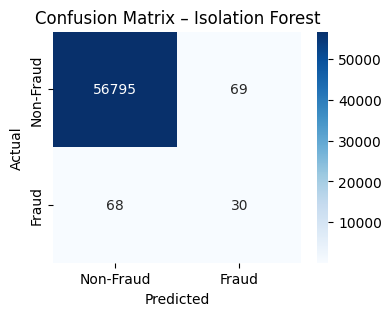

In [129]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Predict: -1 = anomaly, 1 = normal → we map to 1 = fraud, 0 = non-fraud
y_pred_if = iforest.predict(X_test)
y_pred_if = [1 if p == -1 else 0 for p in y_pred_if]

# Print evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred_if))

# Compute pseudo-probability score for AUC
scores_if = iforest.decision_function(X_test) * -1  # invert (lower = more anomalous)
print("AUC Score:", roc_auc_score(y_test, scores_if))

# Confusion matrix
cm_if = confusion_matrix(y_test, y_pred_if)
plt.figure(figsize=(4, 3))
sns.heatmap(cm_if, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Fraud", "Fraud"],
            yticklabels=["Non-Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Isolation Forest")
plt.show()

#### Metric Interpretation:

- **Precision (Class 1 = Fraud): 0.30**  
The model correctly identifies 30% of the transactions it flags as fraud. This low precision indicates a relatively high false positive rate, which is expected given the model does not use labels during training.

- **Recall (Class 1 = Fraud): 0.31**  
Isolation Forest detects 31% of actual fraud cases. This suggests that while the model has some ability to identify anomalous behavior, it misses the majority of true fraud transactions.

- **F1-score (Class 1 = Fraud): 0.30**  
The F1-score reflects the modest performance of the model in balancing detection and error rate. It is not competitive with supervised models but demonstrates minimal anomaly detection capability.

- **Accuracy: 1.00**  
As in previous models, accuracy is misleading due to the highly imbalanced dataset. Most transactions are non-fraud, and correctly labeling them inflates the score.

- **AUC Score: 0.96**  
The model shows a strong ability to rank transactions by their likelihood of being anomalous. Despite low precision and recall, the high AUC indicates that the anomaly scores it generates still have discriminative value.


#### Overall Performance:

Although Isolation Forest does not perform well in terms of precision or recall, this is expected for an unsupervised anomaly detection model. It does not rely on labeled data and instead uses deviation from normal patterns to identify potential fraud. Its strong AUC score (0.96) suggests that it effectively assigns higher anomaly scores to fraudulent transactions, making it a valuable baseline for evaluating the robustness of supervised models and the effectiveness of poisoning defenses.

In [131]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

log_result({
    'Attack Type': 'Clean',
    'Polluted Ratio': 0,
    'Model': 'Isolation Forest',
    'AUC': roc_auc_score(y_test, scores_if), 
    'F1': f1_score(y_test, y_pred_if),
    'Precision': precision_score(y_test, y_pred_if),
    'Recall': recall_score(y_test, y_pred_if)
})

## 1.6 Overall Baseline Models Comparison Summary

In [165]:
import pandas as pd
df_results = pd.read_csv('results/baseline_results.csv')
df_results

,Attack Type,Polluted Ratio,Model,AUC,F1,Precision,Recall
0,Clean,0.0,Logistic Regression,0.971162,0.112853,0.060120,0.918367
1,Clean,0.0,Random Forest,0.953000,0.839080,0.960526,0.744898
2,Clean,0.0,XGBoost,0.975516,0.656250,0.531646,0.857143
3,Clean,0.0,Isolation Forest,0.956256,0.304569,0.303030,0.306122


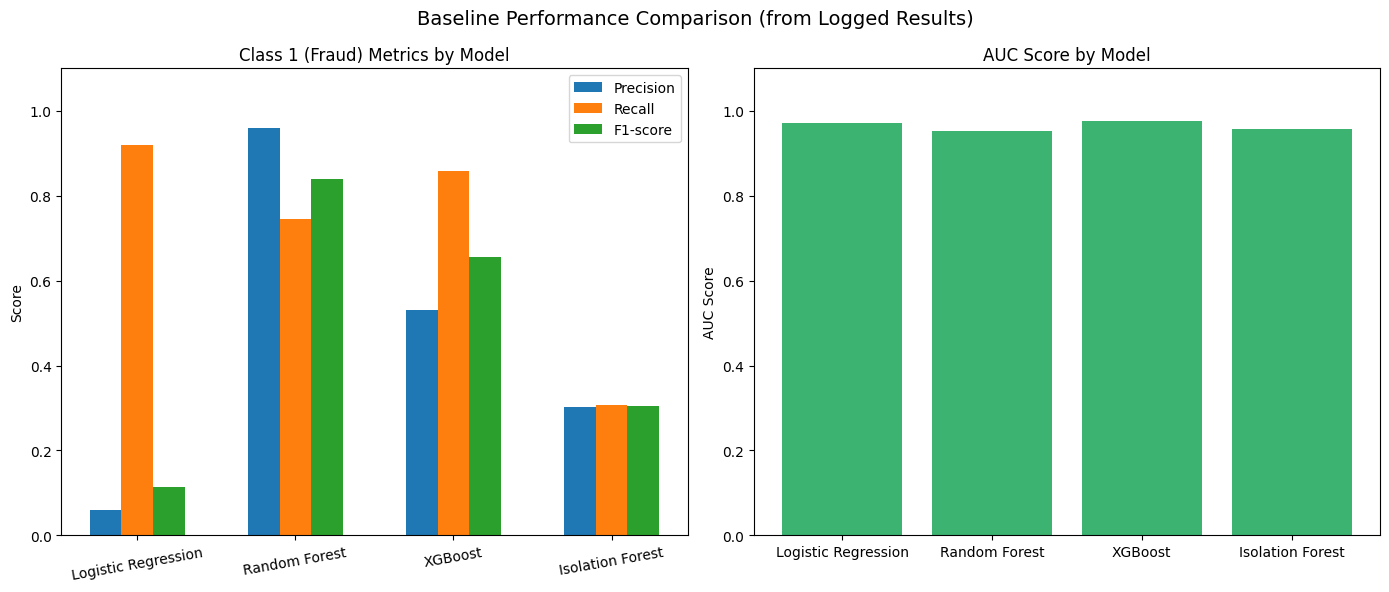

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the logged baseline results
df = pd.read_csv('results/baseline_results.csv')

# Filter only clean baseline (Polluted Ratio == 0)
baseline_df = df[df['Polluted Ratio'] == 0]

# Extract model names and scores
models = baseline_df['Model'].tolist()
precision = baseline_df['Precision'].tolist()
recall = baseline_df['Recall'].tolist()
f1 = baseline_df['F1'].tolist()
auc = baseline_df['AUC'].tolist()

x = np.arange(len(models))

# Create subplot layout
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Left: Precision / Recall / F1
axs[0].bar(x - 0.2, precision, width=0.2, label='Precision')
axs[0].bar(x, recall, width=0.2, label='Recall')
axs[0].bar(x + 0.2, f1, width=0.2, label='F1-score')
axs[0].set_xticks(x)
axs[0].set_xticklabels(models, rotation=10)
axs[0].set_ylim(0, 1.1)
axs[0].set_title("Class 1 (Fraud) Metrics by Model")
axs[0].set_ylabel("Score")
axs[0].legend()

# Right: AUC comparison
axs[1].bar(models, auc, color='mediumseagreen')
axs[1].set_ylim(0, 1.1)
axs[1].set_title("AUC Score by Model")
axs[1].set_ylabel("AUC Score")

# Global settings
plt.suptitle("Baseline Performance Comparison (from Logged Results)", fontsize=14)
plt.tight_layout()
plt.show()

#### Baseline Performance Summary (Based on the Plot Above)

- **Left Subplot – Class 1 Metrics (Fraud Detection):**  
  - **Logistic Regression** shows the highest recall (0.92), meaning it captures most fraud cases, but its precision is extremely low (0.06), causing many false alarms.  
  - **Random Forest** provides the highest precision (0.96) and a good F1-score (0.84), making it the most reliable model when predicting fraud.  
  - **XGBoost** achieves a strong balance between precision and recall, leading to a solid F1-score (0.66).  
  - **Isolation Forest** performs moderately in all metrics, as expected for an unsupervised model.

<br>

- **Right Subplot – AUC Scores:**  
  - **XGBoost** achieves the highest AUC (0.98), indicating that it has the strongest ability to rank transactions by their likelihood of being fraud.  
  - **Isolation Forest** and **Logistic Regression** also have high AUC scores (~0.96–0.97), even though their precision and recall vary.  
  - **Random Forest** has a slightly lower AUC (0.95), but still within the strong range.

Overall, these plots illustrate the trade-offs between precision, recall, and ranking ability across models. XGBoost stands out for its balanced performance and top AUC score, making it a strong candidate for follow-up experiments in data poisoning and threshold sensitivity.

## 1.7 Conclusion and Next Step: Poisoning Experiments

Having established four strong baseline models on the clean dataset, we will now ready to begin the core part of this research: **evaluating the impact of data poisoning attacks on fraud detection systems**.

In the next phase, we will:

- Simulate **label flipping** and **feature manipulation** attacks on the training data
- Vary the degree of poisoning (e.g., 5%, 10%, 20%, etc.)
- Observe how different models (Logistic, RF, XGB, IForest) respond to these adversarial changes
- Measure the **pollution thresholds** beyond which model performance degrades sharply
- Analyze **feature sensitivity** and investigate which features are most vulnerable to manipulation

These experiments will help us understand how robust each model is under malicious data conditions, and which detection strategies are most effective against poisoning attacks.